# DMW - C2 Assignment 1
## k-Times Markov Sampling for SVMC

------

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.linalg import norm
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, mean_absolute_error
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.svm import SVC

# importing the MCMC library
# !pip3 install pymc3
from pymc3 import * 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Loading Data from CSV

In [2]:
data = pd.read_csv("letter-recognition.csv")
data

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,D,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,C,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,T,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,S,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


### Visualizing the Data

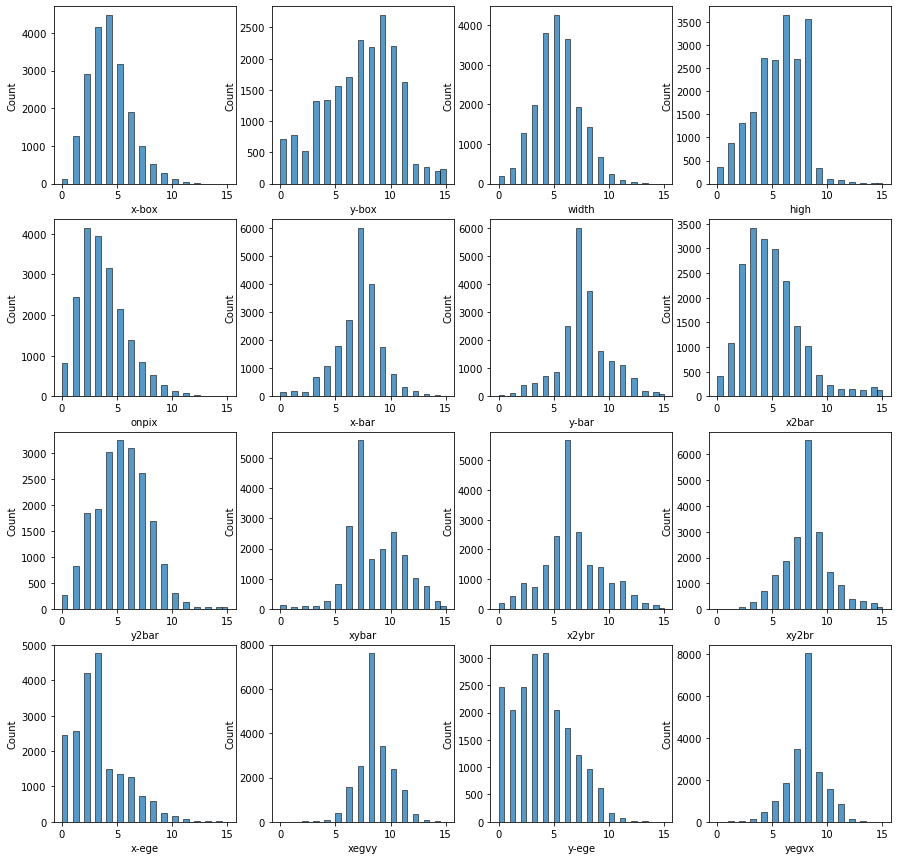

In [3]:
plt.figure(figsize=(15,15))

for i in range(1, 17):
    plt.subplot(4, 4, i)
    sns.histplot(data.iloc[:, i], bins=30)
    
plt.show()

In [4]:
X = np.array(data.iloc[:, 1:])
y = np.array(data.iloc[:, 0])

print("X shape =", X.shape)
helllinger = "poly"
print("y shape =", y.shape)

X shape = (20000, 16)
y shape = (20000,)


## Splitting data into train and test

In [5]:
# splitting it into 2:1 ratio according to the reasearch paper
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=(2/3), random_state=42)

print("X_train shape =", X_train.shape)
print("X_test shape  =", X_test.shape)
print("y_train shape =", y_train.shape)
print("y_test shape  =", y_test.shape)

X_train shape = (13333, 16)
X_test shape  = (6667, 16)
y_train shape = (13333,)
y_test shape  = (6667,)


------

## MCMC SVM Model

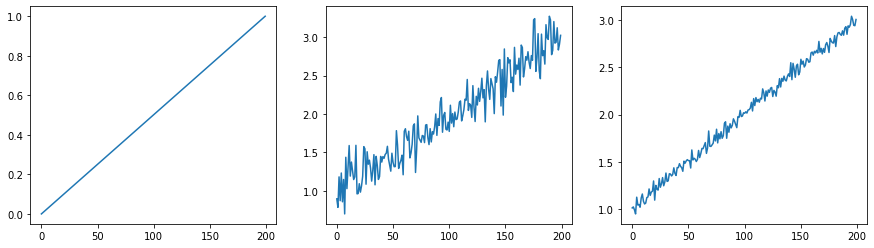

In [6]:
size = 200
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
true_regression_line = true_intercept + true_slope * x
plt.plot(range(size), x)

plt.subplot(1,3,2)
model1 = true_regression_line + np.random.normal(scale=.2, size=size) # Noisy
plt.plot(range(size), model1)

plt.subplot(1,3,3)
model2 = true_regression_line + np.random.normal(scale=.05, size=size) # Less Noisy
plt.plot(range(size), model2)

plt.show()

### MCMC sampling

In [7]:
data = dict(x1=model1, x2=model2, y=true_regression_line)
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    glm.GLM.from_formula('y ~ x1 + x2', data)
    step = NUTS() # Instantiate MCMC sampling algorithm
    trace = sample(1000, step, progressbar=False)

/home/xxdil/.local/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x2, x1, Intercept]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


### hyper-tuning 

In [8]:
intercept = np.median(trace.Intercept)
x1param = np.median(trace.x1)
x2param = np.median(trace.x2)

### Visualization

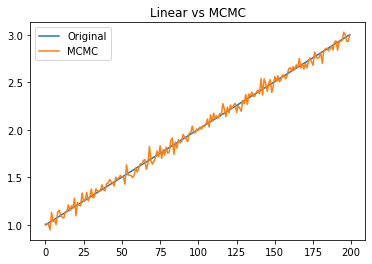

In [9]:
MCMC = intercept+x1param*model1+x2param*model2
true_regression_line = 1 + true_slope * x
plt.plot(range(size), true_regression_line)
plt.plot(range(size), MCMC)
plt.legend(['Original', 'MCMC'])
plt.title('Linear vs MCMC')
plt.show()

------

### Kernel functions

In [10]:
# hellinger kernel
def hellinger(X, Y):
    return norm(np.sqrt(X) - np.sqrt(Y)) / np.sqrt(2)

# intersection kernel
def intersection(data_1, data_2):

    if np.any(data_1 < 0) or np.any(data_2 < 0):
        warnings.warn('Min kernel requires data to be strictly positive!')

    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

### Training 

In [11]:
# Linear Kernel
model_linear = SVC(kernel='linear', C=1E01,tol=0.1)
model_linear.fit(X_train, y_train)
predicted_linear = model_linear.predict(X_test)
print("Linear Kernel Done")

# RBF Kernel
model_rbf = SVC(kernel='rbf', C=1E01,tol=0.1)
model_rbf.fit(X_train, y_train)
predicted_rbf = model_rbf.predict(X_test)
print("RBF Kernel Done")


# Intersection Kernel
model_intersection = SVC(kernel=intersection, C=1E01,tol=0.1)
model_intersection.fit(X_train, y_train)
predicted_intersection = model_intersection.predict(X_test)
print("Intersection Kernel Done")


# Hellinger Kernel
model_hellinger = SVC(kernel=helllinger, C=1E01,tol=0.1)
model_hellinger.fit(X_train, y_train)
predicted_hellinger = model_hellinger.predict(X_test)
print("Hellinger Kernel Done")

# Chi^2 Kernel
model_chi2 = SVC(kernel=chi2_kernel, C=1E01,tol=0.1)
model_chi2.fit(X_train, y_train)
predicted_chi2 = model_chi2.predict(X_test)
print("Chi^2 Kernel Done")

Linear Kernel Done
RBF Kernel Done
Intersection Kernel Done
Hellinger Kernel Done
Chi^2 Kernel Done


### Prediction

In [12]:
accuracy = accuracy_score(y_test, predicted_linear)
print("Error linear kernel : %.2f%%" % (1-accuracy))

accuracy = accuracy_score(y_test, predicted_rbf)
print("Error RBF kernel : %.2f%%" % (1-accuracy))

accuracy = accuracy_score(y_test, predicted_intersection)
print("Error Intersection kernel : %.2f%%" % (1-accuracy))

accuracy = accuracy_score(y_test, predicted_hellinger)
print("Error Hellinger kernel : %.2f%%" % (1-accuracy))

accuracy = accuracy_score(y_test, predicted_chi2)
print("Error Chi^2 kernel : %.2f%%" % (1-accuracy))

Error linear kernel : 0.15%
Error RBF kernel : 0.04%
Error Intersection kernel : 0.08%
Error Hellinger kernel : 0.05%
Error Chi^2 kernel : 0.03%


### Results (Confusion Matrix)

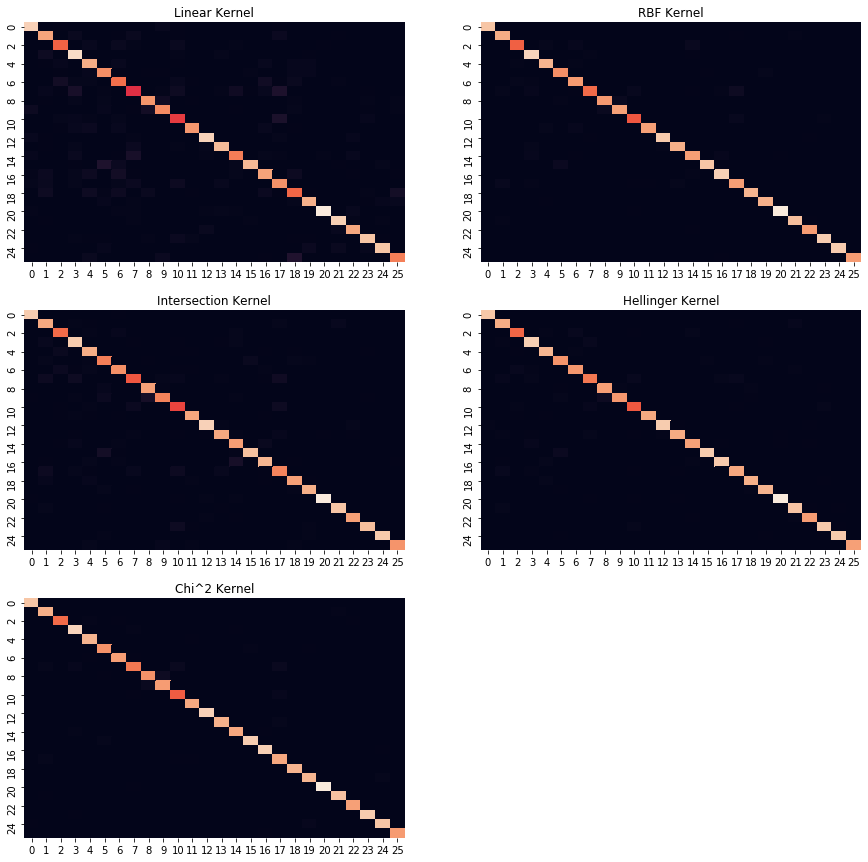

In [13]:
plt.subplots(figsize=(15,15))

plt.subplot(3,2,1)
cf_matrix = confusion_matrix(y_test, predicted_linear)
plt.title('Linear Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,2)
cf_matrix = confusion_matrix(y_test, predicted_rbf)
plt.title('RBF Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,3)
cf_matrix = confusion_matrix(y_test, predicted_intersection)
plt.title('Intersection Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,4)
cf_matrix = confusion_matrix(y_test, predicted_hellinger)
plt.title('Hellinger Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,5)
cf_matrix = confusion_matrix(y_test, predicted_chi2)
plt.title('Chi^2 Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.show()